Event Driven Simulation 

In [2]:
%reset


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


TO DO: SINR variiert, CoMP Scheduling Procedure

In [13]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson


In [10]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

SCHEDULE_T=2 #Clock des Schedulers 

#function to monitor the level of the different queues
def monitor(queue,monitor): 
    monitor.update({env.now: queue.level})
    return monitor

def calculate_tbs(sinr):
    mapping=pd.read_csv('Data/sinr-tbs-mapping.csv')
    tbs=mapping.iloc[sinr].values[1]
    return tbs

#scheduler takes packets from the queues according to the capacity of each user
def scheduler(env, users, SCHEDULE_T):
    
    prb_number=100
    counter=1 #counts the number of scheduling procedures
    alpha=-np.log10(0.01)/100
    
    while True: #größte Warteschlange wird auch bedient
        
        yield env.timeout(SCHEDULE_T) #for each ms the scheduling is active -> per TTI
        print('Scheduling', env.now)
        metric=np.array([]) 
        users[0].mon= monitor(users[0].queue,users[0].mon)
        users[120].mon= monitor(users[120].queue,users[120].mon)
        users[100].mon= monitor(users[100].queue,users[100].mon)
        
        for i in np.arange(np.size(users)): 
            if(users[i].qos==1):
                metric=np.append(metric, (alpha*users[i].queue.level*(users[i].cp/users[i].mR)))  #list the metric of all UEs in the process 
                users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer
                    
            elif(users[i].qos==0):
                if(users[i].queue.level>0):
                    
                    metric=np.append(metric,(users[i].cp/users[i].mR))
                    users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer
                if(users[i].queue.level==0):
                    metric=np.append(metric,0)
                    users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer

        
        sched_user_list = (-metric).argsort() # wählt die 5 UEs mit größter Metrik aus #find UE with maximal metric that will be used for scheduling
        
        #print(sched_user_list)    
        #print(users[2].queue.level)
        remaining_prbs=prb_number
        
        k=0
        #print('New scheduling round')
        while(remaining_prbs>0):
            sched_user=sched_user_list[k]

            queue_size=users[sched_user].queue.level
            tbs=users[sched_user].tbs

            if((queue_size/tbs)<=remaining_prbs and queue_size>0):
                sched_size=queue_size
                remaining_prbs=remaining_prbs-np.ceil(queue_size/tbs)
            elif((queue_size/tbs)>remaining_prbs):
                sched_size=remaining_prbs*tbs
                remaining_prbs=remaining_prbs-sched_size
                
            elif(queue_size==0):
                print('empty queue')
                break
            else:
                print('something went wrong')
            #print('user:',sched_user)    
            #print('queue size before:',queue_size)
            #print('mR before:',users[sched_user].mR)
            users[sched_user].mR=users[sched_user].mR+(1/counter)*sched_size
            users[sched_user].queue.get(sched_size)
            #print('queue size after:',users[sched_user].queue.level)
            #print('mR afer:',users[sched_user].mR)
            k=k+1
        counter=counter+1
        

        
            
class ue:
    def __init__(self,sinr,sinr2,cell1,cell2,env,qos):
        self.sinr=sinr
        self.sinr2=sinr2
        self.tbs=calculate_tbs(sinr)
        self.tbs2=calculate_tbs(sinr2)
        self.qos=qos
        self.cp=0.5*0.7*20000000*np.log2(1+np.power(10,sinr/10))/8000 #division by 8000 to determine number of bits that can be transmitted per TTI (1ms)
        self.cp2=0.5*0.7*20000000*np.log2(1+np.power(10,sinr2/10))/8000
        self.cell1=cell1
        self.cell2=cell2
        self.mR=0.1 #mittlere Rate
        self.queue=simpy.Container(env)
        self.mon={}
        self.metric=self.sinr+self.queue.level
        
    def rt_user(self,env):
        on_off=1
        counter=0
        start=0
        while True:
            if(start==0):
                start=1
                yield env.timeout(random.randint(0,200))
            elif(on_off==1 and counter<3000):
                self.queue.put(160) #20 bytes
                mon= monitor(self.queue,self.mon)
                #yield env.timeout(poisson.rvs(6, 1))
                #print('On Phase')
                #print(self.queue.level)
                counter=counter+20
                #print(counter)
                yield env.timeout(20) #every 20ms new packet
            elif(on_off==0):
                on_off=1

                yield env.timeout(3000) #3s no packet to be sent
            elif(on_off==1 and counter>=3000):
                on_off=0
                counter=0
                #print('change from ON-OFF')
            
    def user_packets(self,env,packet_arr):
        while True:
            #print('o-user')
            self.queue.put(2000)
            #self.mon= monitor(self.queue,self.mon)
            yield env.timeout(poisson.rvs(packet_arr, 1))
            

    def streaming_user(self,env):
        while True:
            #print('o-user')
            self.queue.put(1500) #1080p-> 1.5 Mbps 
            #self.mon= monitor(self.queue,self.mon)
            yield env.timeout(2)
    
    #Noch sehr vereinfacht!!!
    def sinr_variator(self,env):
        change=round(np.random.normal(0,0.5))
        if((self.sinr+change)>-10 and (self.sinr+change)<30): 
            self.sinr=self.sinr +change
            self.sinr2=self.sinr2+change 
        yield env.timeout(2000)

##Ausführung der Simulation

env=simpy.Environment()
#env = simpy.rt.RealtimeEnvironment(factor=1/10)

ue_list=np.array([])
#ue_list=np.append(ue_list,ue(15,5,'19','18',env,0))
#ue_list=np.append(ue_list,ue(15,5,'19','18',env,0))
#ue_list=np.append(ue_list,ue(20,7,'19','18',env,0))


for i in np.arange(0,100):
    ue_list=np.append(ue_list,ue(random.randint(0,20),random.randint(10,25),'19','18',env,0))
    

ue_list=np.append(ue_list,ue(random.randint(0,20),random.randint(10,25),'19','18',env,1))
    

for i in np.arange(0,20):
    ue_list=np.append(ue_list,ue(random.randint(0,20),random.randint(10,25),'19','18',env,1))
    
env.process(scheduler(env,ue_list,SCHEDULE_T))

for i in np.arange(0,100):
    env.process(ue_list[i].user_packets(env,500))
    #env.process(ue_list[i].sinr_variator()) #movement

env.process(ue_list[100].streaming_user(env))
#env.process(ue_list[100].sinr_variator()) #movement

    
for i in np.arange(101,121):
    env.process(ue_list[i].rt_user(env))
    #env.process(ue_list[i].sinr_variator()) #movement


env.run(until=3000)

Scheduling 2
Scheduling 4
Scheduling 6
Scheduling 8
Scheduling 10
Scheduling 12
Scheduling 14
Scheduling 16
Scheduling 18
Scheduling 20
Scheduling 22
Scheduling 24
Scheduling 26
Scheduling 28
Scheduling 30
Scheduling 32
Scheduling 34
Scheduling 36
Scheduling 38
Scheduling 40
Scheduling 42
Scheduling 44
Scheduling 46
Scheduling 48
Scheduling 50
Scheduling 52
Scheduling 54
Scheduling 56
Scheduling 58
Scheduling 60
Scheduling 62
Scheduling 64
Scheduling 66
Scheduling 68
Scheduling 70
Scheduling 72
Scheduling 74
Scheduling 76
Scheduling 78
Scheduling 80
Scheduling 82
Scheduling 84
Scheduling 86
Scheduling 88
Scheduling 90
Scheduling 92
Scheduling 94


<ipython-input-10-89a3ba1edb2f>:43: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,(users[i].cp/users[i].mR))
<ipython-input-10-89a3ba1edb2f>:38: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric, (alpha*users[i].queue.level*(users[i].cp/users[i].mR)))  #list the metric of all UEs in the process
<ipython-input-10-89a3ba1edb2f>:38: RuntimeWarning: invalid value encountered in double_scalars
  metric=np.append(metric, (alpha*users[i].queue.level*(users[i].cp/users[i].mR)))  #list the metric of all UEs in the process


Scheduling 96
Scheduling 98
Scheduling 100
Scheduling 102
Scheduling 104
Scheduling 106
Scheduling 108
Scheduling 110
Scheduling 112
Scheduling 114
Scheduling 116
Scheduling 118
Scheduling 120
Scheduling 122
Scheduling 124
Scheduling 126
Scheduling 128
Scheduling 130
Scheduling 132
Scheduling 134
Scheduling 136
Scheduling 138
Scheduling 140
Scheduling 142
empty queue
Scheduling 144
empty queue
Scheduling 146
empty queue
Scheduling 148
empty queue
Scheduling 150
empty queue
Scheduling 152
empty queue
Scheduling 154
empty queue
Scheduling 156
empty queue
Scheduling 158
empty queue
Scheduling 160
empty queue
Scheduling 162
empty queue
Scheduling 164
empty queue
Scheduling 166
empty queue
Scheduling 168
empty queue
Scheduling 170
empty queue
Scheduling 172
empty queue
Scheduling 174
empty queue
Scheduling 176
empty queue
Scheduling 178
empty queue
Scheduling 180
empty queue
Scheduling 182
empty queue
Scheduling 184
empty queue
Scheduling 186
empty queue
Scheduling 188
empty queue
Schedulin

empty queue
Scheduling 828
empty queue
Scheduling 830
empty queue
Scheduling 832
empty queue
Scheduling 834
empty queue
Scheduling 836
empty queue
Scheduling 838
empty queue
Scheduling 840
empty queue
Scheduling 842
empty queue
Scheduling 844
empty queue
Scheduling 846
empty queue
Scheduling 848
empty queue
Scheduling 850
empty queue
Scheduling 852
empty queue
Scheduling 854
empty queue
Scheduling 856
empty queue
Scheduling 858
empty queue
Scheduling 860
empty queue
Scheduling 862
empty queue
Scheduling 864
empty queue
Scheduling 866
empty queue
Scheduling 868
empty queue
Scheduling 870
empty queue
Scheduling 872
empty queue
Scheduling 874
empty queue
Scheduling 876
empty queue
Scheduling 878
empty queue
Scheduling 880
empty queue
Scheduling 882
empty queue
Scheduling 884
empty queue
Scheduling 886
empty queue
Scheduling 888
empty queue
Scheduling 890
empty queue
Scheduling 892
empty queue
Scheduling 894
empty queue
Scheduling 896
empty queue
Scheduling 898
empty queue
Scheduling 900
e

Scheduling 1510
Scheduling 1512
Scheduling 1514
Scheduling 1516
Scheduling 1518
Scheduling 1520
Scheduling 1522
Scheduling 1524
Scheduling 1526
Scheduling 1528
Scheduling 1530
Scheduling 1532
Scheduling 1534
Scheduling 1536
Scheduling 1538
Scheduling 1540
Scheduling 1542
Scheduling 1544
Scheduling 1546
Scheduling 1548
Scheduling 1550
Scheduling 1552
Scheduling 1554
Scheduling 1556
Scheduling 1558
Scheduling 1560
Scheduling 1562
Scheduling 1564
Scheduling 1566
Scheduling 1568
Scheduling 1570
Scheduling 1572
Scheduling 1574
Scheduling 1576
Scheduling 1578
Scheduling 1580
Scheduling 1582
Scheduling 1584
Scheduling 1586
Scheduling 1588
Scheduling 1590
Scheduling 1592
Scheduling 1594
Scheduling 1596
Scheduling 1598
empty queue
Scheduling 1600
empty queue
Scheduling 1602
empty queue
Scheduling 1604
empty queue
Scheduling 1606
empty queue
Scheduling 1608
empty queue
Scheduling 1610
empty queue
Scheduling 1612
empty queue
Scheduling 1614
Scheduling 1616
empty queue
Scheduling 1618
empty queue


empty queue
Scheduling 2206
empty queue
Scheduling 2208
empty queue
Scheduling 2210
empty queue
Scheduling 2212
empty queue
Scheduling 2214
empty queue
Scheduling 2216
empty queue
Scheduling 2218
empty queue
Scheduling 2220
empty queue
Scheduling 2222
empty queue
Scheduling 2224
empty queue
Scheduling 2226
empty queue
Scheduling 2228
empty queue
Scheduling 2230
empty queue
Scheduling 2232
empty queue
Scheduling 2234
empty queue
Scheduling 2236
empty queue
Scheduling 2238
empty queue
Scheduling 2240
empty queue
Scheduling 2242
empty queue
Scheduling 2244
empty queue
Scheduling 2246
empty queue
Scheduling 2248
empty queue
Scheduling 2250
empty queue
Scheduling 2252
empty queue
Scheduling 2254
empty queue
Scheduling 2256
empty queue
Scheduling 2258
empty queue
Scheduling 2260
empty queue
Scheduling 2262
empty queue
Scheduling 2264
empty queue
Scheduling 2266
empty queue
Scheduling 2268
empty queue
Scheduling 2270
empty queue
Scheduling 2272
empty queue
Scheduling 2274
empty queue
Scheduli

empty queue
Scheduling 2886
empty queue
Scheduling 2888
empty queue
Scheduling 2890
empty queue
Scheduling 2892
empty queue
Scheduling 2894
empty queue
Scheduling 2896
empty queue
Scheduling 2898
empty queue
Scheduling 2900
empty queue
Scheduling 2902
empty queue
Scheduling 2904
empty queue
Scheduling 2906
empty queue
Scheduling 2908
empty queue
Scheduling 2910
empty queue
Scheduling 2912
empty queue
Scheduling 2914
empty queue
Scheduling 2916
empty queue
Scheduling 2918
Scheduling 2920
Scheduling 2922
Scheduling 2924
Scheduling 2926
empty queue
Scheduling 2928
empty queue
Scheduling 2930
empty queue
Scheduling 2932
empty queue
Scheduling 2934
empty queue
Scheduling 2936
Scheduling 2938
empty queue
Scheduling 2940
empty queue
Scheduling 2942
empty queue
Scheduling 2944
Scheduling 2946
Scheduling 2948
Scheduling 2950
Scheduling 2952
Scheduling 2954
Scheduling 2956
Scheduling 2958
Scheduling 2960
Scheduling 2962
Scheduling 2964
Scheduling 2966
Scheduling 2968
Scheduling 2970
empty queue


In [118]:
round(np.random.normal(0,0.5))

1

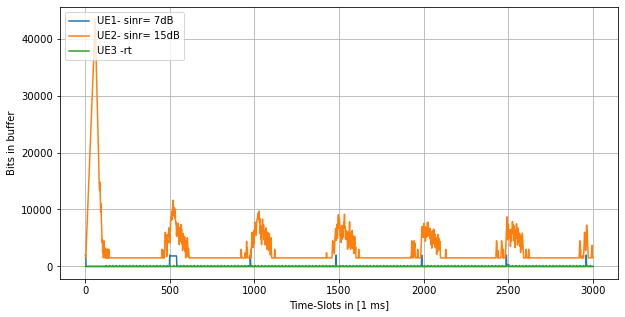

In [11]:
plt.figure(figsize=(10,5))
plt.plot(ue_list[0].mon.keys(),ue_list[0].mon.values(),label='UE1- sinr= 7dB')
plt.plot(ue_list[100].mon.keys(),ue_list[100].mon.values(),label='UE2- sinr= 15dB')
plt.plot(ue_list[120].mon.keys(),ue_list[120].mon.values(),label='UE3 -rt')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()
#plt.axvline(x = 13, color = 'b', label = 'axvline - full height')
#plt.axvline(x = 27, color = 'b', label = 'axvline - full height')

#Erklärung für high peaks am anfang -> am ANfang werden alle Prozesse gleichzeitig "aktiviert" ->viele Pakete entstehen zur gleichen Zeit

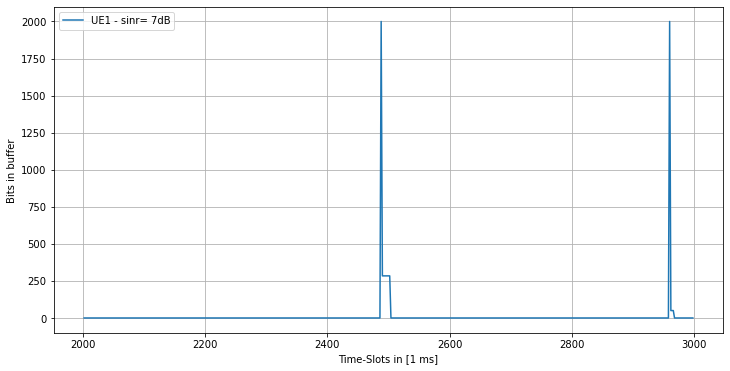

In [12]:
plt.figure(figsize=(12,6))
plt.plot(list(ue_list[0].mon.keys())[1000:3000],list(ue_list[0].mon.values())[1000:3000],label='UE1 - sinr= 7dB')
#plt.plot(list(ue_list[100].mon.keys())[2000:300],list(ue_list[100].mon.values())[2000:3000],label='UE2 - sinr= 15dB')
#lt.plot(list(ue_list[120].mon.keys())[2000:3000],list(ue_list[120].mon.values())[2000:3000],label='UE3 - rt')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()
#plt.axvline(x = 13, color = 'b', label = 'axvline - full height')
#plt.axvline(x = 27, color = 'b', label = 'axvline - full height')

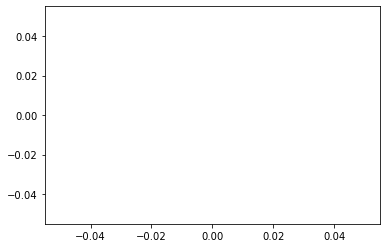

In [71]:
plt.plot(list(ue_list[0].mon.keys())[2000:3000],list(ue_list[0].mon.values())[2000:3000],label='UE1 - sinr= 7dB')

In [26]:
ue_list[300].tbs

123.75

In [54]:
ue_list[100].queue.level

1500.0